This script attempts to remove diurnal, then long-term seasonal oscillations from the isoprene time series data for use with SARIMA. To do this, fast Fourier transforms are used with high and low-pass filters.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from statsmodels.graphics.tsaplots import plot_acf
from scipy.signal import butter, filtfilt 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
def bair_data_read_in(site_dir:str):
    df_lst = []
    for file in os.listdir(site_dir):
        try:
            df = pd.read_csv(rf'{site_dir}/{file}', header=1)
            df['time'] = pd.to_datetime(df['time'], unit='s')
            df['time'] = df['time'].dt.round('min')
            df_lst.append(df)
        except:
            pass
    data = pd.concat(df_lst)
    data = data.sort_values('time')
    try:
        data = data.rename(columns={'wsp_avg_ms': 'wsp', 'wdr_avg': 'wdr'})
    except AttributeError:
        pass
    if 'met' in site_dir:
        data = data[['time', 'wsp', 'wdr', 'temp_f']]
    else:
        data = data[['time', 'isoprene']]
    return data

In [3]:
isoprene = bair_data_read_in(r'/Users/gabegreenberg/Boulder_AIR/BoulderAIR_data/LUR/voc')
print(isoprene)

                    time  isoprene
0    2020-02-01 00:42:00   0.01731
1    2020-02-01 02:06:00   0.01313
2    2020-02-01 03:31:00   0.01731
3    2020-02-01 04:55:00   0.01851
4    2020-02-01 06:20:00   0.01373
...                  ...       ...
1023 2025-02-19 00:05:00   0.00504
1024 2025-02-19 01:05:00   0.00504
1025 2025-02-19 02:05:00   0.00504
1026 2025-02-19 03:05:00   0.00504
1027 2025-02-19 04:05:00   0.00504

[40055 rows x 2 columns]


In [4]:
# imputting the data to ensure regular spacing 
isoprene['time'] = isoprene['time'].dt.round('H')
isoprene.set_index('time', inplace=True)
isoprene = isoprene.resample('H').mean()
isoprene['isoprene'] = isoprene['isoprene'].interpolate(method='linear') 
hourly_isoprene = isoprene.reset_index()

/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_55506/1195136126.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  isoprene['time'] = isoprene['time'].dt.round('H')
/var/folders/2c/kht9wb5n56xdj4mxjj2k7twr0000gn/T/ipykernel_55506/1195136126.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  isoprene = isoprene.resample('H').mean()


In [5]:
n = len(hourly_isoprene['isoprene'])
samp_f = 1

# run the forier transform
fft_iso = rfft(hourly_isoprene['isoprene'])
fft_time = rfftfreq(n, 1 / samp_f)

print(1/24)
print(1/8760) # num hours in a year
# these print statments tell me where I should expect to find peaks 

0.041666666666666664
0.00011415525114155251


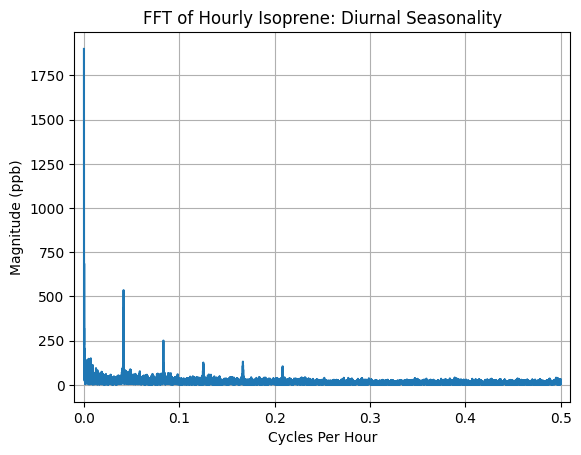

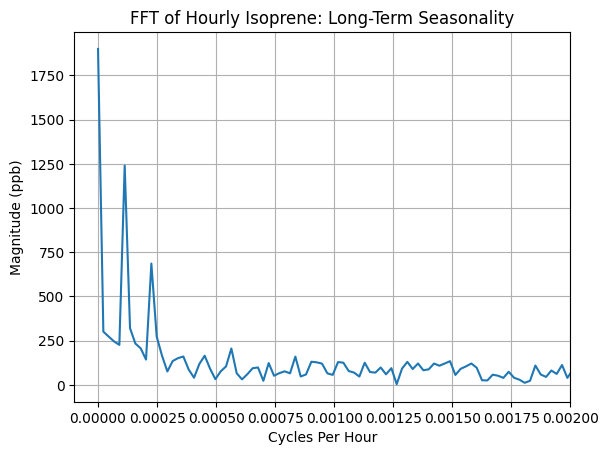

In [6]:
plt.plot(fft_time, np.abs(fft_iso))
plt.xlim((-.01, .51))
plt.title('FFT of Hourly Isoprene: Diurnal Seasonality')
plt.xlabel('Cycles Per Hour')
plt.ylabel('Magnitude (ppb)')
plt.grid()
plt.show()

plt.plot(fft_time, np.abs(fft_iso))
plt.xlim((-.0001, .002))
plt.title('FFT of Hourly Isoprene: Long-Term Seasonality')
plt.xlabel('Cycles Per Hour')
plt.ylabel('Magnitude (ppb)')
plt.grid()
plt.show()

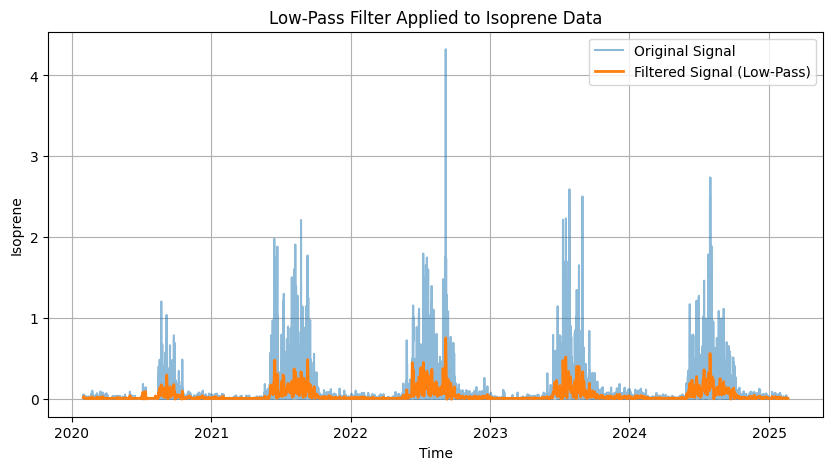

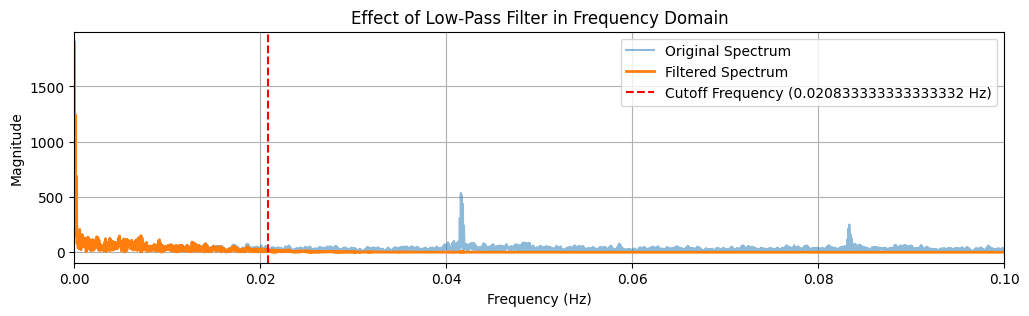

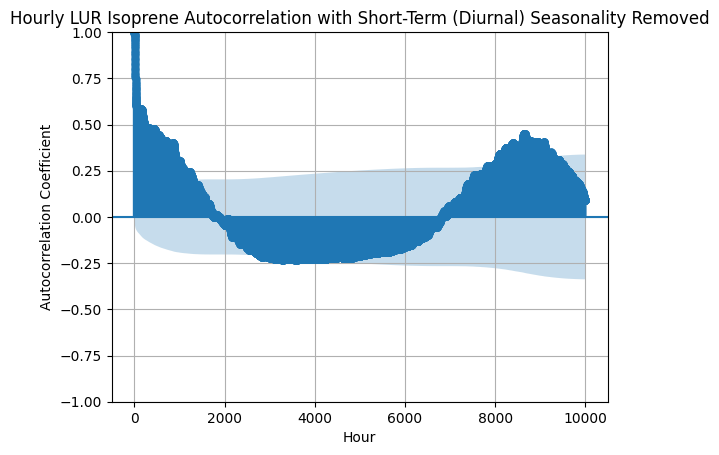

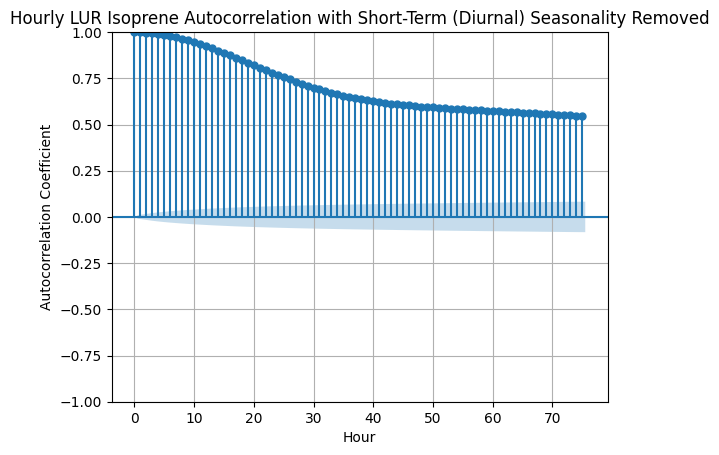

In [7]:
# using a lowpass filter on the data 
# I used this: https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7 to help me figure out how to apply a lowpass filter
# I used a cutoff value smaller then 1/24 to make sure the signal gets removed, but not so small that it effects the yearly signal
cutoff_freq = 1 / 48 
nyquist = 0.5 * samp_f  

def lowpass_filter_func(data, cutoff, samp_f, order=3):
    normal_cutoff = cutoff / nyquist  
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filt_data = filtfilt(b, a, data)
    return filt_data

seasonal_signal = lowpass_filter_func(hourly_isoprene['isoprene'], cutoff_freq, samp_f)

#original vs. filtered signal in time domain
plt.figure(figsize=(10, 5))
plt.plot(hourly_isoprene['time'], hourly_isoprene['isoprene'], label="Original Signal", alpha=0.5)
plt.plot(hourly_isoprene['time'], seasonal_signal, label="Filtered Signal (Low-Pass)", linewidth=2)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Isoprene")
plt.title("Low-Pass Filter Applied to Isoprene Data")
plt.grid()
plt.show()

original_isoprene = np.abs(rfft(hourly_isoprene['isoprene'])) 
filtered_isoprene = np.abs(rfft(seasonal_signal))  

#original vs. filtered signal in frequency domain
plt.figure(figsize=(12, 3))
plt.plot(fft_time, original_isoprene, label="Original Spectrum", alpha=0.5)
plt.plot(fft_time, filtered_isoprene, label="Filtered Spectrum", linewidth=2)
plt.axvline(cutoff_freq, color='r', linestyle='--', label=f"Cutoff Frequency ({cutoff_freq} Hz)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Effect of Low-Pass Filter in Frequency Domain")
plt.xlim(0, 0.1)
plt.grid()
plt.show()

# I used acf_plots to check if I was able to remove the dirunal cycles visualy whithout removing the longer term seasonal cycle
plot_acf(seasonal_signal, lags=10000)  
plt.title('Hourly LUR Isoprene Autocorrelation with Short-Term (Diurnal) Seasonality Removed')
plt.xlabel('Hour')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()
plt.show()

plot_acf(seasonal_signal, lags=75)  
plt.title('Hourly LUR Isoprene Autocorrelation with Short-Term (Diurnal) Seasonality Removed')
plt.xlabel('Hour')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()
plt.show()


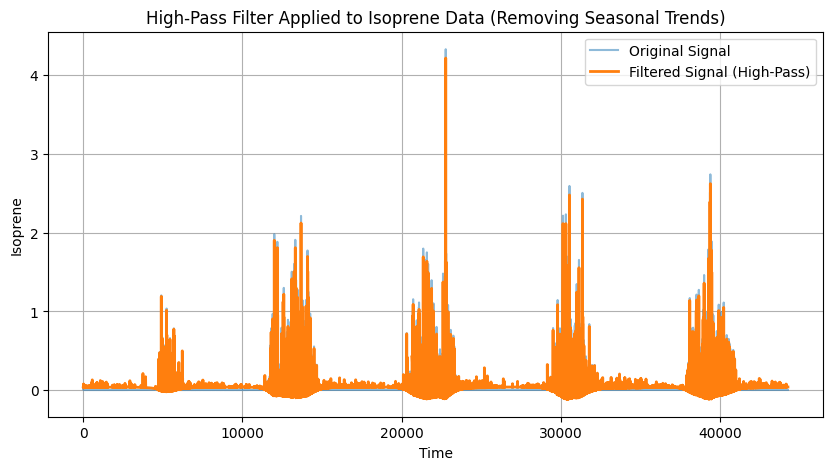

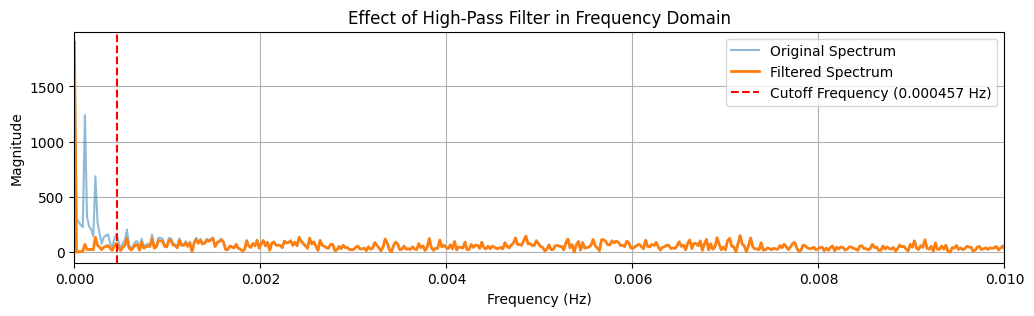

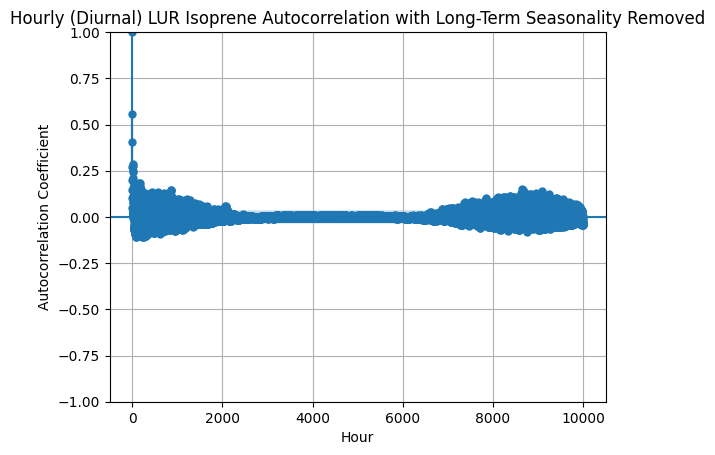

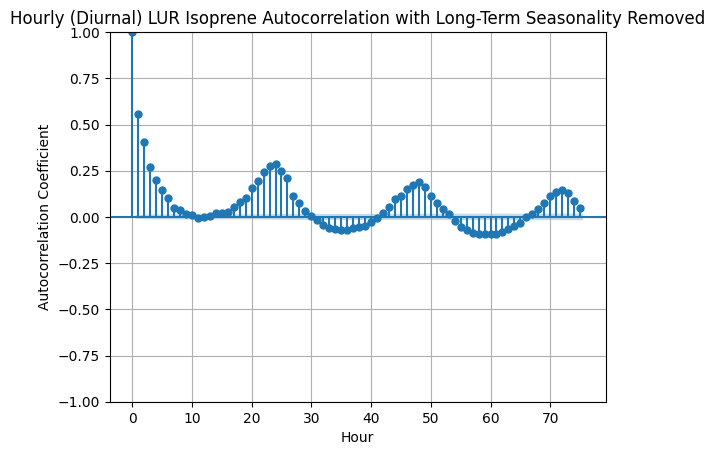

In [8]:
# using a highpass filter on the data trying to remove long term seasonality 
# I used this: https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7 to help me figure out how to apply the filter
# I used a cutoff value larger then 1/(365 * 24) to make sure the seasoanl signal gets removed, but not so big that it impacts the diurnal cycle
cutoff_freq = 1 / ( 6 * 365)  
def highpass_filter_func(data, cutoff, samp_f, order=1):
    normal_cutoff = cutoff / nyquist  
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filt_data = filtfilt(b, a, data)
    return filt_data

iso_mean = np.mean(hourly_isoprene['isoprene'])
diurnal_signal = highpass_filter_func(hourly_isoprene['isoprene'], cutoff_freq, samp_f)
# adding the mean back in to try to reduce artifacting (negative values that keep showing up in the inverted ftt)
diurnal_signal += iso_mean  

plt.figure(figsize=(10, 5))
plt.plot(hourly_isoprene.index, hourly_isoprene['isoprene'], label="Original Signal", alpha=0.5)
plt.plot(hourly_isoprene.index, diurnal_signal, label="Filtered Signal (High-Pass)", linewidth=2)
plt.legend()
plt.xlabel("Time")
plt.ylabel("Isoprene")
plt.title("High-Pass Filter Applied to Isoprene Data (Removing Seasonal Trends)")
plt.grid()
plt.show()

original_isoprene = np.abs(rfft(hourly_isoprene['isoprene']))  
filtered_isoprene = np.abs(rfft(diurnal_signal))  

plt.figure(figsize=(12, 3))
plt.plot(fft_time, original_isoprene, label="Original Spectrum", alpha=0.5)
plt.plot(fft_time, filtered_isoprene, label="Filtered Spectrum", linewidth=2)
plt.axvline(cutoff_freq, color='r', linestyle='--', label=f"Cutoff Frequency ({cutoff_freq:.6f} Hz)")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Effect of High-Pass Filter in Frequency Domain")
plt.xlim(0, 0.01) 
plt.grid()
plt.show()

plot_acf(diurnal_signal, lags=10000)  
plt.title('Hourly (Diurnal) LUR Isoprene Autocorrelation with Long-Term Seasonality Removed')
plt.xlabel('Hour')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()
plt.show()

plot_acf(diurnal_signal, lags=75)  
plt.title('Hourly (Diurnal) LUR Isoprene Autocorrelation with Long-Term Seasonality Removed')
plt.xlabel('Hour')
plt.ylabel('Autocorrelation Coefficient')
plt.grid()
plt.show()

# unfortunatly I wasn't able to compleetly remove the artifacting when applying the hypass filter there are clearly negative values that shouldn't exist

In [ ]:

#here I am testing to see how long it takes to run an SARIMA model on the whole dataset after filtering (to just include the dirunal signal + some variance)
#I referenced this: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
sarima_model = SARIMAX(diurnal_signal, 
                    order=(1,1,1),    
                    seasonal_order=(1,1,1,24),  
                    enforce_stationarity=False, 
                    enforce_invertibility=False)

m_fit = sarima_model.fit()
# on my local matchine it took 2min 45sec to run so doing this itterativly to get preditctions for a year+ shifting the window by an hour at a time of data does not seem doable 
# would take roughly 2.45 * 8760 * 2(I would also have to run this for the long term seasonal signal) = 294.45 hours (12ish days) to run assuming I don't run into memory issues first.